# How the Scientific Python ecosystem helps answering fundamental questions of the Universe
**Vangelis Kourlitis, Technical University of Munich**    
Gordon Watts, University of Washington  
Matthew Feickert, University of Wisconsin-Madison  
Alexander Held, University of Wisconsin–Madison  

## _Disclaimer_ 
This is partially a presentation, partially a demonstration. The aim is to showcase how libraries of the Scientific Python ecosystem are used in fundamental particle physics research.

ATLAS has recently released a significant amount of Open Data for research. We hope scientists, and especially computer scientists, explore them and embrase on a constuctive dialogue with us. This notebook demonstrates a simplified analysis of those data.

## The LHC and the ATLAS experiment

The ATLAS experiment at CERN explores vast amounts of physics data to answer the most fundamental questions of the Universe.

* What is Dark Matter, and can we produce dark matter particles in the LHC?
* Are there extra spatial dimensions beyond the familiar three?
* Why is there more matter than antimatter in the universe?
* Are there new fundamental particles or forces?
* ...

The Large Hadron Collider (LHC) is a circular particle accelerator that provides high energy proton-proton collisions (_events_), from which new particles are being produced due to the basic equation that relates energy and matter:  
$$E = mc^2$$

<img src="figures/LHC_collisions.jpeg" width="800"/>

The ATLAS detector is mounted in one of the four interaction points of the LHC -- other detectors are mounted in other interaction points.

<img src="figures/LHC.png" width="800"/>

ATLAS is a complex detector, composed by various sub-detectors, each one specialized to the detection of a specific signature/particle.

Those outgoing, newly produced particles, leave signatures in the ATLAS detector. Physicists reconstruct particle objects from those signatures.

<img src="figures/ATLASImage.jpg" width="800"/>

And a transverse view of the detector showing actually the specific signatures different particles are leaving.

<img src="figures/Schematic-of-how-different-particles-interact-with-the-ATLAS-detector.png" width="700"/>

## The ATLAS physics data

Those reconstructed particle objects, after various processing and data reduction steps, are stored in a compact data format called [PHYSLITE](https://opendata.atlas.cern/docs/documentation/data_format/physlite/) ($\sim 10\,\text{kB/event}$). Physicists analyze PHYSLITE data to study the properties of the particles produced in each event.

PHYSLITE data are highly structured and can be represented in a tabular format. However, since each event can contain variable number of particles, this will be a _jagged_ table. Learn more about [jagged data](https://en.wikipedia.org/wiki/Jagged_array) in the Part 3 of the tutorial [Thinking In Arrays](https://github.com/ekourlit/scipy2024-tutorial-thinking-in-arrays).

The [`awkward`](https://github.com/scikit-hep/awkward) is a Python library that provides NumPy-like idioms for arbitrary data structures. 

For example:

In [1]:
import awkward as ak

example = ak.Array([
    [{"x": 1.1, "y": 1.2, "z": 3.1}, {"x": 2.2, "y": 1.3, "z": 2}, {"x": 3.3, "y": 2.4, "z": 4.2}],     # this event contains three electrons with properties x, y, and z
    [],                                                                                                 # this event contains no electrons
    [{"x": 4.4, "y": 1.1, "z": 1}, {"x": 5.5, "y": 4.2, "z": 3.2}]                                      # this event contains two electrons with properties x, y, and z
])

ak.to_dataframe(example)

x    y    z
entry subentry               
0     0         1.1  1.2  3.1
      1         2.2  1.3  2.0
      2         3.3  2.4  4.2
2     0         4.4  1.1  1.0
      1         5.5  4.2  3.2

What is well defined are the properties of the particles we store in PHYSLITE files. Those are all listed in:

https://atlas-physlite-content-opendata.web.cern.ch/

## ATLAS Open Data

**ATLAS has recently released 65 TB of PHYSLITE open data for research -- this is over 7 billion LHC collision events!** Those are all the data collected by the experiment during the 2015 and 2016. The release is accompanied by additional 2 billion events of simulated “Monte Carlo” data, which are essential for carrying out a physics analysis. The simulated data have almost the same structure as the real data. We're going to use these simulated events for today's demonstration for practical purposes.

Read about our open data release at: 

https://atlas.cern/Updates/News/Open-Data-Research

Our open data portal provides in depth information about the data along with analysis tutorials:

https://opendata.atlas.cern/

## Reading PHYSLITE files

PHYSLITE files are of type [ROOT](https://root.cern/) files. This is a very common file type used in particle physics and needs specialized decompression and interpretation routines to load the data in memory (e.g. in awkward arrays). For such purpose we will use the [`uproot`](https://github.com/scikit-hep/uproot5) library.

So now we have introduced the two main libraries we utilize for particle physics data analysis in the Scientific Python ecosystem:
1. `awkward`
2. `uproot`

Those two libraries are in principle enough for a physicist to acquire an in-memory representation of the data. However, to make our life easier we will use an additional library which is build on top of `awkward` and `uproot`. This is [`coffea`](https://github.com/CoffeaTeam/coffea) and provides basic tools and wrappers for all the typical needs of particle physics data analysts.

Let's import some required classes and functions from `coffea` along with `numpy`.

In [2]:
import coffea
print("coffea version: ",coffea.__version__)
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools
import numpy as np

coffea version:  2024.6.1


## Analysis introduction

The particular analysis case we will use for this demonstration is the search for the Higgs boson, an elementary particle discovered in 2012. The Higgs boson was predicted by the BEH mechanism, the mechanism that explains how all the particles in the Universe acquire mass. The discovery of the Higgs boson by the ATLAS and CMS experiments at CERN awarded the Nobel prize for physics to Francois Englert and Peter W. Higgs in 2013.

<img src="figures/nobel_2013.jpg" width="500"/>

Read more about this landmark discovery at https://atlas.cern/Discover/Physics/Higgs

The Higgs boson is produced by the proton-proton collisions of the LHC.

It is extremely short lived (about $10^{-22}$ seconds) and immediately decays to other particles. For this scenario we will study the decays of the Higgs boson to two other elementary particles, the Z bosons. 

In their turn, the Z bosons are extremely short lived as well. However, at about 3% of the time, they decay to two electrons. **Electrons are also elementary particle but stable ones!** Therefore we will look at our detector for electron signatures. In particular four electrons.

![](figures/fig_01d.png)

This is an actual four electron signature registered at the ATLAS detector in 2012 and contributed to the Higgs boson discovery:

<img src="figures/higgs_event_display.png" width="900"/>

## Looking into a file

Let's now load a PHYSLITE file containing simulated event data describing the production and decay of Higgs bosons. Those data can be found at DOI:[10.7483/OPENDATA.ATLAS.Z2J9.709J](http://doi.org/10.7483/OPENDATA.ATLAS.Z2J9.709J). 

You can download those files at your local machine or you can stream them directly. For this demo I will use the [XCache](http://slateci.io/XCache/) service of our compute facility to speed things up.

In [3]:
# Hgg -> 4l sample

# local
# file_path = '/MyMachine/Downloads/DAOD_PHYSLITE.38191712._000001.pool.root.1'

# stream
# file_path = "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1"

# XCache
file_path = "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1"

To make the loading lighter, we will use the `filter_name` function, in order to load only the properties needed. Then we will use `coffea`'s `NanoEventsFactory.from_root` to load the file. 

This is actually a delayed computation. `coffea` is using `dask` as a backend to construct a delayed task graph representing our analysis. So there is some metadata reading but not actual number crunching until `compute()` is called.

_Some warnings will appear as we're still working with `uproot` to correctly interpret all the properties stored in PHYSLITE. We will suppress for now._

In [4]:
import warnings
warnings.filterwarnings("ignore")

def filter_name(name):
    '''
    Load only the properties/variables needed.
    '''
    return name in [
        "EventInfoAuxDyn.mcEventWeights",
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        "AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose",
        "AnalysisElectronsAuxDyn.charge",
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        "AnalysisMuonsAuxDyn.quality"
    ]

events = NanoEventsFactory.from_root(
    {file_path: "CollectionTree"}, # all the event properties are stored in the so called CollectionTree
    schemaclass=PHYSLITESchema, # tell NanoEventsFactory.from_root that you read a PHYSLITE file
    uproot_options=dict(filter_name=filter_name)
).events()

### Highly structured jagged data

In [5]:
events.fields

['Electrons', 'EventInfo', 'Muons']

In [6]:
events.Electrons.compute()

<ElectronArray [[Electron, ..., Electron], ...] type='50000 * var * electron'>

In [7]:
events.Electrons.fields

['pt', '_eventindex', 'eta', 'phi', 'm', 'charge', 'DFCommonElectronsLHLoose']

## Data selection and feature engineering

The data in every event of that simulated sample come from Higgs boson that decay to Z bosons. In particular, the Z boson can also decay to another elementary particle called muon -- thus we could alternatively look for four muon events -- but we will neglect those cases.

Furthermore, we always apply some kinematic and quality criteria to our reconstructed particles (electrons and muons). Those criteria are defined by the `object_selection` function. After we get our _good_ particles definition, we will use them to only select events that fullfil those requirements for further processing. This is achieved by the `region_selection` function.

Last but not least, we want to use the properties of the four electrons to deduct a critical property of the Higgs boson, its mass. In particular, we will calculate the so-called "invariant" mass, which is an inferred mass of a particle (Higgs) from its decay products (electrons). For this we use the function `calculate_inv_mass`. Read more about the invariant mass here: https://atlas.cern/glossary/mass.

In [8]:
GeV = 1000

def object_selection(events):
    '''
    Select objects based on kinematic and quality criteria
    '''
    
    electrons = events.Electrons
    muons = events.Muons
    
    electron_reqs = (electrons.pt/GeV > 20) & \
                    (np.abs(electrons.eta) < 2.47) & \
                    (electrons.DFCommonElectronsLHLoose == 1)
                    
    muon_reqs = (muons.pt/GeV > 20) & \
                (np.abs(muons.eta) < 2.7) & \
                (muons.quality == 2)
    
    # only keep objects that pass our requirements
    electrons = electrons[electron_reqs]
    muons = muons[muon_reqs]
    
    return electrons, muons

def region_selection(electrons, muons):
    '''
    Select events based on object multiplicity
    '''
    
    selections = PackedSelection(dtype='uint64')
    # basic selection criteria
    selections.add("exactly_4e", ak.num(electrons) == 4)
    selections.add("total_e_charge_zero", ak.sum(electrons.charge, axis=1) == 0)
    selections.add("exactly_0m", ak.num(muons) == 0)
    # selection criteria combination
    selections.add("4e0m", selections.all("exactly_4e", "total_e_charge_zero", "exactly_0m"))
    
    return selections.all("4e0m")

def calculate_inv_mass(electrons):
    '''
    Construct invariant mass observable
    '''
    
    # reconstruct Higgs as 4e system
    candidates = ak.combinations(electrons, 4)
    e1, e2, e3, e4 = ak.unzip(candidates)
    candidates["p4"] = e1 + e2 + e3 + e4
    higgs_mass = candidates["p4"].mass
    observable = ak.flatten(higgs_mass/GeV)
    
    return observable

<br>

In [9]:
# select objects and events
el, mu = object_selection(events)
selection_4e0m = region_selection(el, mu)

As mentined already, `coffea` constructs a task graph representing our analysis. We can visualise it before we actually compute it.

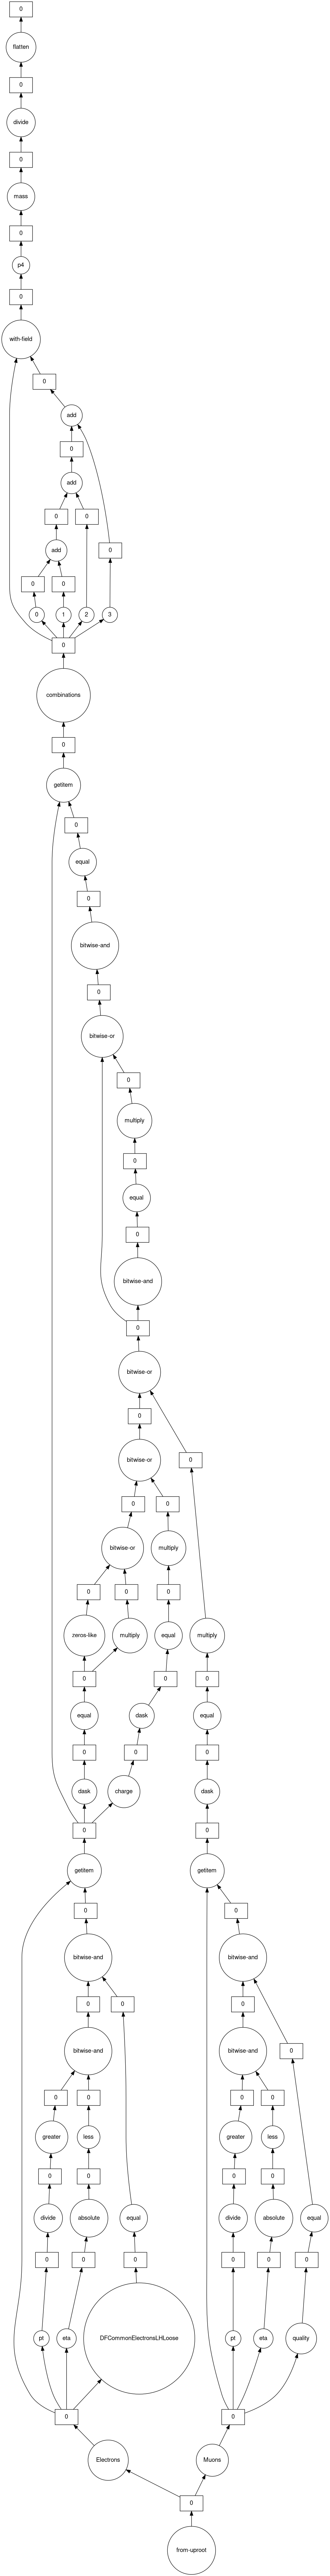

In [10]:
calculate_inv_mass( el[selection_4e0m] ).visualize()

_The above is the raw task graph but `dask` actually optimizes it before it runs._

We will use `matplotlib` to plot a histogram of the invariant mass of each four-electron group in each event.

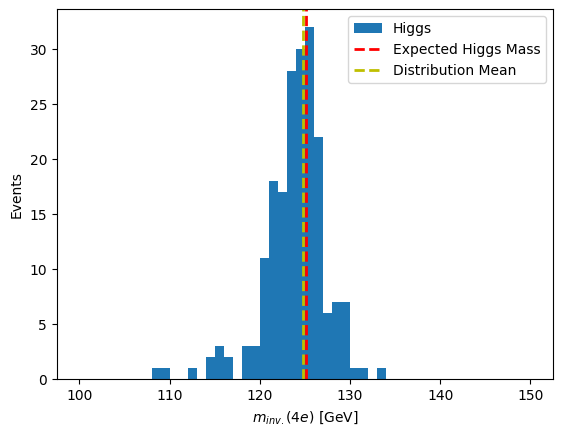

In [11]:
from matplotlib import pyplot as plt

# observable calculation
inv_masses = calculate_inv_mass(el[selection_4e0m]).compute()
# mean value calculation
mean_value = np.mean(inv_masses)

# plotting
plt.hist(inv_masses, bins=50, range=(100, 150), label='Higgs')
plt.axvline(125.11, color='r', linestyle='dashed', linewidth=2, label='Expected Higgs Mass') # known only after the discovery in 2012
plt.axvline(mean_value, color='y', linestyle='dashed', linewidth=2, label='Distribution Mean')
plt.xlabel(r"$m_{inv.}(4e)$ [GeV]")
plt.ylabel('Events')
plt.legend()
plt.show()

## Scale out over multiple files

`coffea` supplies facilities for horizontally scaling an analysis in order to reduce time-to-insight in a way that is largely independent of the resource the analysis is being executed on. By making use of modern big-data technologies like `dask` it is possible with to scale an analysis from testing on a laptop to a large multi-core server, computing clusters and super-computers without the need to alter or otherwise adapt the analysis code itself.

First, we will define a `fileset` dictionary that contains the file paths and some metadata. Those metadata are needed in order to weight each simulated sample according to the probability of a particular physics process occurs in nature. Our open data release is accompanied with a [metadata table](https://opendata.atlas.cern/docs/documentation/overview_data/data_research_2024#metadata).

In [12]:
# XCache
fileset = {
            "Higgs"  : {
                        'files': {
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000002.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000005.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000006.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000007.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000008.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000009.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000010.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000011.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000012.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000013.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000014.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000016.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000017.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000018.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000019.pool.root.1' : 'CollectionTree',
                                   'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1' : 'CollectionTree'
                                 },
                        'metadata': {'process': 'Higgs', 'xsec': 28.3, 'genFiltEff': 1.240E-04, 'kFactor': 1.45, 'sumOfWeights': 114108.08}
                      }
          }

# pre-process
samples, _ = dataset_tools.preprocess(fileset)

As we plan to process a large number of events, we would better return a more compact representation of the result instead of a huge array of length O(Million).

We would write a function that actually returns a histogram of the invariant mass per file. For the histogram creation we will use the `hist` library which provides some handy functionalities useful to particle physics and also native `dask` distribution.

In [13]:
import hist
import dask

# create histogram with observables
def create_histogram(events):
    hist_4e0m = (
        hist.dask.Hist.new.Reg(50, 100, 150, name='m_inv', label=r"$m_{inv.}(4e)$ [GeV]")
        .StrCat([], name='process', label='Process', growth=True)
        .Weight()
        )
    
    # read metadata
    process_name = events.metadata['process']
    x_sec = events.metadata["xsec"]
    gen_filt_eff = events.metadata["genFiltEff"]
    k_factor = events.metadata["kFactor"]
    sum_of_weights = events.metadata["sumOfWeights"]
    
    # as mentined already, the actual analysis code remains the same!
    # select objects and events
    el, mu = object_selection(events)
    selection_4e0m = region_selection(el, mu)

    # normalization for MC
    lumi = 36100. # /pb This is the luminosity (the amount of real data collected) corresponding to the open data released
    xsec_weight = x_sec * gen_filt_eff * k_factor * lumi / sum_of_weights
    print(f"Processing {process_name} with xsec weight {xsec_weight}")
    mc_weight = events.EventInfo[selection_4e0m][:, 1]["mcEventWeights"]
    
    # observable calculation and histogram filling
    inv_mass = calculate_inv_mass(el[selection_4e0m])
    hist_4e0m.fill(inv_mass, weight=mc_weight*xsec_weight, process=process_name)

    return hist_4e0m

Now we can create the task graph using the `coffea` utilities we imported earlier.

In [14]:
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name)
                                      )

Processing Higgs with xsec weight 0.001609781480855694


Finally we can compute the task graph directly with `dask`. This is where the number crunching actually happens where we process 1,598,000 events from an $\sim11\,\text{GB}$ dataset.

In [15]:
%%time

# execute
(out, ) = dask.compute(tasks)

CPU times: user 55.3 s, sys: 3.45 s, total: 58.7 s
Wall time: 53.1 s


Just a small final processing step and we can plot the final histogram.

In [16]:
# stack all the histograms together, as we processed each file separately
full_histogram = sum(hist for hist in out.values())

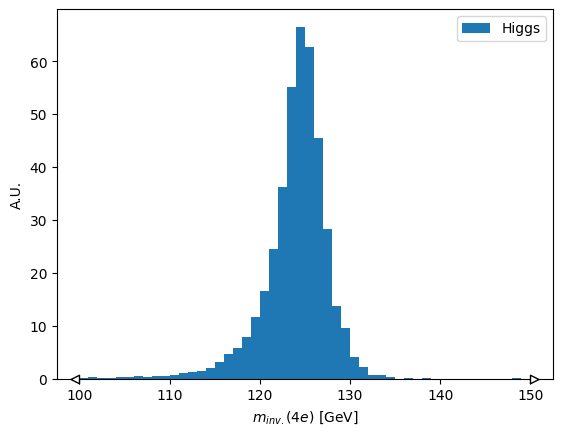

In [17]:
# plot
artists = full_histogram.plot(histtype="fill")

ax = artists[0].stairs.axes
ax.legend()
ax.set_ylabel("A.U.");

## Closing remarks

With this demonstrator we showcased how the Scientific Python ecosystem is being used for modern data analytics at scale in the fundamental research. Of course realistic scenarios include further complexity as more files of real and simulated data, statistical interpretation and often machine learning algorithms. The python libraries used were:
1. `awkward`
2. `uproot`
3. `coffea`
4. `numpy`
5. `dask`
6. `hist`
7. `matplotlib`

A large collection of libraries for particle physics data analysis in Python can be found in the [scikit-hep](https://github.com/scikit-hep/) repository.

**ATLAS is also advocating the use of the recent open data release for research. We hope to embrace on a dialogue and collaboration with non-ATLAS scientists and especially with computer scientists while exploring our datasets.**

Please get in touch!

vangelis.kourlitis@cern.ch

## Acknowledgement

We thank the [IRIS-HEP](https://iris-hep.org/) [Scalable Systems Laboratory](https://iris-hep.org/ssl.html) for their support in setting up the compute infrastructure needed to run this demonstration.
